In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [19]:
students_data = {
    'student': ['Вася', 'Петя', 'Кристина', 'Полина', 'Егор', 'Света'],
    'attends_all_the_lessons': [1, 0, 0, 0, 1, 0],
    'completes_all_the_homeworks': [0, 0, 1, 1, 1, 0],
    'participates_in_contests': [0, 0, 1, 0, 0, 0],
    'does_not_has_c_in_diploma': [1, 0, 1, 0, 1, 0]
}
students_pd = pd.DataFrame(students_data)

feature_names = ['attends_all_the_lessons', 'completes_all_the_homeworks', 'participates_in_contests']
target_name = 'does_not_has_c_in_diploma'

In [20]:
def calc_gini(values):
    
    if not values: #на случай, если переданный список не будет содержать элементов
        return 0
    
    total_count = len(values) #считаем общее количество значений в списке

    unique_classes = set(values) #set() оставит только уникальные значения

    sum_of_squares = 0 #будем считать квадрат доли каждого класса в эту переменную

    for cls in unique_classes:
        p_i = values.count(cls) / total_count #считаем долю каждого класса в списке
        sum_of_squares += p_i ** 2

    gini = 1 - sum_of_squares

    return gini

In [21]:
def find_best_split(dataframe , feature_names, target_name):
    init_gini = calc_gini(dataframe[target_name].tolist())

    max_information_gain = 0.0
    best_split = None

    for feature_name in feature_names:
        split_value = 0.5

        left_group = dataframe[dataframe[feature_name] <= split_value]
        right_group = dataframe[dataframe[feature_name] > split_value]

        gini_left = calc_gini(left_group[target_name].tolist())
        gini_right = calc_gini(right_group[target_name].tolist())

        total_count = len(dataframe)

        if len(left_group) == 0 or len(right_group) == 0:
            continue

        ratio_left = len(left_group) / total_count
        ratio_right = len(right_group) / total_count

        information_gain = init_gini - (gini_left * ratio_left + gini_right * ratio_right)

        if information_gain > max_information_gain:
            max_information_gain = information_gain
            best_split = (feature_name, split_value)

    return best_split, max_information_gain

In [22]:
def build_tree(dataframe, feature_names, target_name):
    best_split, max_information_gain = find_best_split(dataframe, feature_names, target_name)

    if max_information_gain == 0:
        # ...то делить дальше бессмысленно. Мы в "листе" дерева.
        # Нам нужно вернуть предсказание для этого листа.
        # Логично предсказывать тот класс, который встречается чаще всего.
        # В pandas это делается с помощью .mode()[0]
        leaf_prediction = dataframe[target_name].mode()[0]
        return leaf_prediction
    
    else:

        split_feature, split_value = best_split

        left_group = dataframe[dataframe[split_feature] <= split_value]
        right_group = dataframe[dataframe[split_feature] > split_value]

        left_branch = build_tree(left_group, feature_names, target_name)
        right_branch = build_tree(right_group, feature_names, target_name)

        return {
            'feature': split_feature,
            'split_value': split_value,
            'left_branch': left_branch,
            'right_branch': right_branch
        }

In [23]:
my_tree = build_tree(students_pd, feature_names, target_name)

# И посмотрим, что получилось
from pprint import pprint
pprint(my_tree) 

{'feature': 'attends_all_the_lessons',
 'left_branch': {'feature': 'participates_in_contests',
                 'left_branch': np.int64(0),
                 'right_branch': np.int64(1),
                 'split_value': 0.5},
 'right_branch': np.int64(1),
 'split_value': 0.5}


In [24]:
def calc_squared_error(values):
    mean_value = values.mean()

    return sum([(v - mean_value) ** 2 for v in values]) / len(values)

In [29]:
def find_best_split_for_regression(dataframe , feature_names, target_name):
    init_squared_error = calc_squared_error(dataframe[target_name])

    max_mse_reduction = 0.0
    best_split = None

    for feature_name in feature_names:

        values = sorted(set(dataframe[feature_name]))
        potential_splits = []

        for i in range(len(values) - 1):
            split_value = (values[i] + values[i+1]) / 2
            potential_splits.append(split_value)

            for split_value in potential_splits:

                left_group = dataframe[dataframe[feature_name] <= split_value]
                right_group = dataframe[dataframe[feature_name] > split_value]

                squared_error_left = calc_squared_error(left_group[target_name])
                squared_error_right = calc_squared_error(right_group[target_name])

                total_count = len(dataframe)

                if len(left_group) == 0 or len(right_group) == 0:
                    continue

                ratio_left = len(left_group) / total_count
                ratio_right = len(right_group) / total_count

                mse_reduction = init_squared_error - (squared_error_left * ratio_left + squared_error_right * ratio_right)

                if mse_reduction > max_mse_reduction:
                    max_mse_reduction = mse_reduction
                    best_split = (feature_name, split_value)

    return best_split, max_mse_reduction

In [30]:
def build_tree_for_regression(dataframe, feature_names, target_name):
    best_split, max_mse_reduction = find_best_split_for_regression(dataframe, feature_names, target_name)

    if max_mse_reduction == 0:
        
        leaf_prediction = dataframe[target_name].mean()
        return leaf_prediction
    
    else:

        split_feature, split_value = best_split

        left_group = dataframe[dataframe[split_feature] <= split_value]
        right_group = dataframe[dataframe[split_feature] > split_value]

        left_branch = build_tree_for_regression(left_group, feature_names, target_name)
        right_branch = build_tree_for_regression(right_group, feature_names, target_name)

        return {
            'feature': split_feature,
            'split_value': split_value,
            'left_branch': left_branch,
            'right_branch': right_branch
        }

In [31]:
students_data_new = {
    'student': ['Вася', 'Петя', 'Кристина', 'Полина', 'Егор', 'Света'],
    'attends_all_the_lessons': [1, 0, 0, 0, 1, 0],
    'completed_homeworks_count': [3, 2, 4, 2, 4, 2],
    'participates_in_contests': [0, 0, 1, 0, 0, 0],
    'final_score_in_exam': [79, 63, 91, 68, 87, 52]
}

# Создание DataFrame
students_pd_new = pd.DataFrame(students_data_new)

# Также определим списки признаков и цели, чтобы все было в одном месте
feature_names_new = ['attends_all_the_lessons', 'completed_homeworks_count', 'participates_in_contests']
target_name_new = 'final_score_in_exam'

In [32]:
build_tree_for_regression(students_pd_new, feature_names_new, target_name_new)

{'feature': 'completed_homeworks_count',
 'split_value': 2.5,
 'left_branch': np.float64(61.0),
 'right_branch': {'feature': 'completed_homeworks_count',
  'split_value': 3.5,
  'left_branch': np.float64(79.0),
  'right_branch': {'feature': 'attends_all_the_lessons',
   'split_value': 0.5,
   'left_branch': np.float64(91.0),
   'right_branch': np.float64(87.0)}}}

[Text(0.3333333333333333, 0.875, 'completes_all_the_homeworks <= 2.5\nsquared_error = 186.889\nsamples = 6\nvalue = 73.333'),
 Text(0.16666666666666666, 0.625, 'squared_error = 44.667\nsamples = 3\nvalue = 61.0'),
 Text(0.25, 0.75, 'True  '),
 Text(0.5, 0.625, 'completes_all_the_homeworks <= 3.5\nsquared_error = 24.889\nsamples = 3\nvalue = 85.667'),
 Text(0.41666666666666663, 0.75, '  False'),
 Text(0.3333333333333333, 0.375, 'squared_error = 0.0\nsamples = 1\nvalue = 79.0'),
 Text(0.6666666666666666, 0.375, 'participates_in_contests <= 0.5\nsquared_error = 4.0\nsamples = 2\nvalue = 89.0'),
 Text(0.5, 0.125, 'squared_error = 0.0\nsamples = 1\nvalue = 87.0'),
 Text(0.8333333333333334, 0.125, 'squared_error = 0.0\nsamples = 1\nvalue = 91.0')]

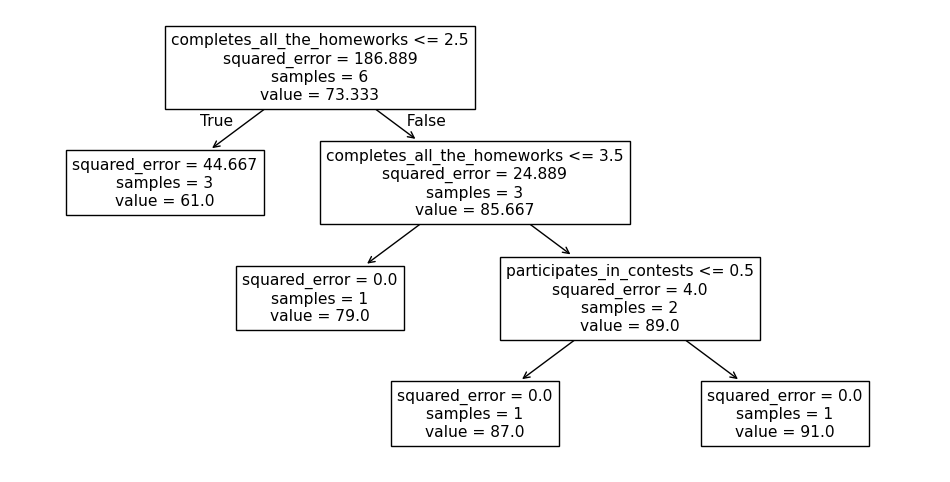

In [34]:
model_new = DecisionTreeRegressor()
model_new.fit(
    X=students_pd_new[feature_names_new],
    y=students_pd_new[target_name_new]
)

plt.figure(figsize=[12, 6])
tree.plot_tree(model_new, feature_names=list(feature_names))